In [1]:
import numpy as np
from toy_datasets import *
from BootstrappedNonparametrics.nonparametrics import *
import os 
import math
import pdb
import random
import time
import multiprocessing as mp
from scipy.sparse import csr_matrix 
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn import mixture 
from joblib import  Parallel, delayed
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import scipy.io as sio
from scipy.spatial.distance import squareform
import math


def compute_pointwise_ber(idx, xdata, gdist, mask, ylabel, neighborhood_size=None, kernel=None):

    if neighborhood_size is not None:
        neighborhoodsize=neighborhood_size
        samp = xdata[idx, :].reshape(1, -1)
        if sum(mask[idx])<neighborhood_size:
            kerneldata = xdata
            kernelgraph = gdist
            kernellabel = ylabel
        else:
            kerneldata = xdata[mask[idx],:]
            kernelgraph = gdist[mask[idx],:][:, mask[idx,:]]
            kernellabel = ylabel[mask[idx]]
        neighb = KNeighborsClassifier(n_neighbors=neighborhood_size)
        neighb = neighb.fit(kerneldata, kernellabel)
        dists, ids = neighb.kneighbors(samp)
        ids = ids.ravel()
        kerneldata = kerneldata[ids, :]
        kernelgraph = gdist[ids,:][:, ids]
        kernellabel = kernellabel[ids]
        
    else:
        kerneldata = xdata[mask[idx],:]
        kernelgraph = gdist[mask[idx],:][:, mask[idx,:]]
        kernellabel = ylabel[mask[idx]]
        neighborhoodsize=len(kerneldata)

#     if kernel=='gaussian':
#         kerneldata = 
        
    nn_indices = compute_neighbors(kerneldata, kerneldata)
    errors = np.sum(np.abs(kernellabel[nn_indices] - kernellabel))
#     localconnect = connect_matrix[mask[idx], :][:, mask[idx]]
#     dense_eudist = squareform(pdist(kerneldata))
#     eudist_csr = csr_matrix(kernelgraph)
#     mst = minimum_spanning_tree(eudist_csr)
#     mst = mst.toarray()
#     edgelist = np.transpose(np.nonzero(mst))

#     errors = np.sum(mst.astype(bool) * localconnect)
#     errors = np.sum(kernellabel[edgelist[:, 0]] != kernellabel[edgelist[:, 1]])

#     Dp = 1 - ((M + N) / (2 * M * N)) * errors
        
    N = np.sum(kernellabel==0)
    M = np.sum(kernellabel==1)
    if N==0 or M==0:
        kerneldp = 1.
        kernelBayesLB = 0.
    else:
        kerneldp = 1 - ((M + N) / (2 * M * N)) * errors
        if kerneldp<=0:
            kerneldp=0.
            kernelBayesLB = 0
        else:
            kernelBayesLB = .5 - .5 * np.sqrt(kerneldp)
#         if kernelBayesLB==math.nan:
#             kernelBayesLB=0.
#     if kerneldp<=0:
#         print(kerneldp, kernelBayesLB)
        
#     print(N, M, kerneldp, errors)
#     if kerneldp==np.nan or kerneldp<=0:
#         kerneldp=1
#         kernelBayesLB=0
    return (kernelBayesLB, kerneldp, neighborhoodsize)

# def compute_pointwise_weight()

<Figure size 432x288 with 0 Axes>

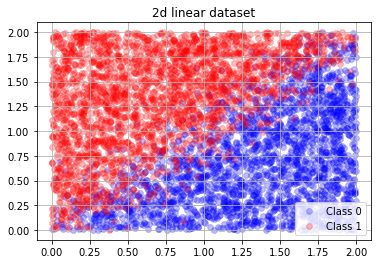

In [3]:
xlin, ylin = gen_linear_dataset(N=5000, sigma=.25, ndim=2)
adjacency_matrix = pairwise_distances(xlin, n_jobs=7)
connect_matrix = pairwise_distances(ylin.reshape(-1,1), n_jobs=7)
plt.figure()
plot_2d_dataset(xlin, ylin, title = '2d linear dataset')
gdist = np.matrix.round(adjacency_matrix, 5)
distancevec = squareform(gdist)
sigma_threshold = .15
neighborhood_radius = np.mean(squareform(gdist)) * sigma_threshold


Mean distance:	 1.0447926701364265 	Neighborhood Threshold:	 0.15671890052046397


Text(0, 0.5, '$x_1$')

<Figure size 432x288 with 0 Axes>

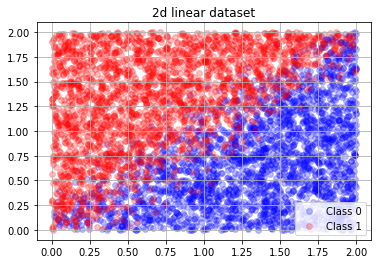

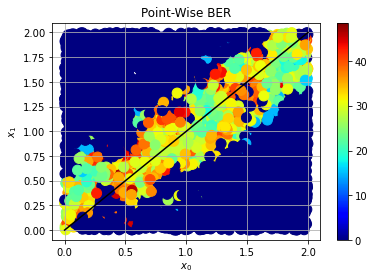

<Figure size 432x288 with 0 Axes>

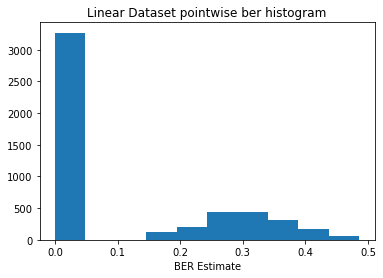

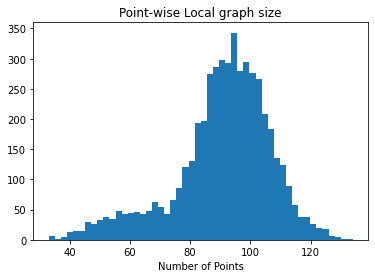

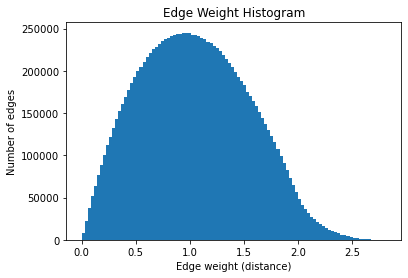

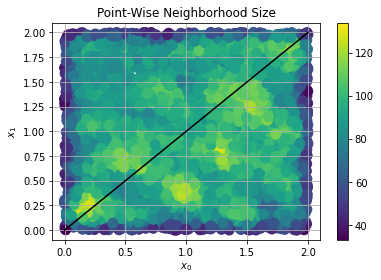

In [4]:
''' Linear dataset pdist, etc '''

xlin, ylin = gen_linear_dataset(N=5000, sigma=.25, ndim=2)
adjacency_matrix = pairwise_distances(xlin, n_jobs=7)
connect_matrix = pairwise_distances(ylin.reshape(-1,1), n_jobs=7)
plt.figure()
plot_2d_dataset(xlin, ylin, title = '2d linear dataset')
gdist = np.matrix.round(adjacency_matrix, 5)
# np.set_printoptions(precision=2)
distancevec = squareform(gdist)
sigma_threshold = .15
neighborhood_radius = np.mean(squareform(gdist)) * sigma_threshold
print('Mean distance:\t', np.mean(distancevec), '\tNeighborhood Threshold:\t', neighborhood_radius)
# adjacency_matrix[:7, :7]
ylinnumeric = ylin.astype('float')
mask = gdist < neighborhood_radius
# [compute_pointwise_ber(idx, xdata = xlin, gdist = gdist, mask = mask, ylabel = ylinnumeric) for idx in range(len(xlin))]
rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xlin, gdist = gdist, mask = mask, ylabel = ylinnumeric) for idx in range(len(xlin)))
pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])

fig = plt.figure()
# ax = plt.gca()

plt.scatter(xlin[:, 0], xlin[:, 1], c=pointwiseBER*100, s=100, cmap=plt.cm.jet)
# plt.scatter(countsGT[gooderrinds], estim_count[gooderrinds])
plt.grid()
plt.colorbar()

plt.plot([0, 2], [0, 2], 'k')
plt.title('Point-Wise BER')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
fig = plt.figure()
# ax = plt.gca()

plt.figure()
# sum(ylinnumeric==0)
plt.hist(pointwiseBER)
plt.xlabel('BER Estimate')
plt.title('Linear Dataset pointwise ber histogram')

# xmask = gdist[maskmatrix]
plt.figure()
# plt.hist('Point-wise Local graph size')
plt.title('Point-wise Local graph size')
plt.xlabel('Local graph size')
plt.xlabel('Number of Points')
plt.hist(sum(mask), bins=50)


plt.figure()
plt.title('Edge Weight Histogram')
plt.xlabel('Edge weight (distance)')
plt.ylabel('Number of edges')
plt.hist(distancevec, bins = 100)
# pointwise_ber()

# idx = 10

plt.figure()
plt.scatter(xlin[:, 0], xlin[:, 1], c=sum(mask), s=100, cmap=plt.cm.viridis)
# plt.scatter(countsGT[gooderrinds], estim_count[gooderrinds])
plt.grid()
plt.colorbar()

plt.plot([0, 2], [0, 2], 'k')
plt.title('Point-Wise Neighborhood Size')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
# ylin.shape

# tmp = [compute_pointwise_ber(idx, xdata = xlin, gdist = gdist, mask = mask, ylabel = ylinnumeric) for idx in range(len(xlin))]


[1.02446306 1.59792376 1.15968918 ... 0.145687   0.25479434 0.09216854]
Mean distance:	 1.0408464920784162 	Neighborhood Threshold:	 0.10408464920784162


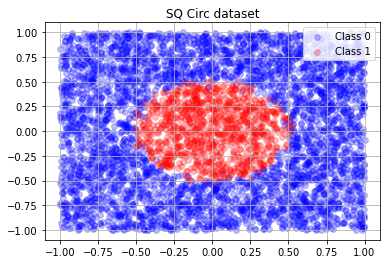

In [5]:
from toy_datasets import *
x0square, x1circle, ysqcirc = inscribed_circle_dataset(N=5000, radius=.5, sidelen=2, sigma=.025)

xsqcirc = np.vstack([x0square, x1circle])
# print(sum(_labels))
plot_2d_dataset(xsqcirc, ysqcirc, title = 'SQ Circ dataset')
ind = ysqcirc==1
print(np.square(xsqcirc[:, 0]) + np.square(xsqcirc[:, 1]))

adjacency_matrix = pairwise_distances(xsqcirc, n_jobs=7)
connect_matrix = pairwise_distances(ysqcirc.reshape(-1,1), n_jobs=7)

from scipy.spatial.distance import squareform
gdist = np.matrix.round(adjacency_matrix, 5)
distancevec = squareform(gdist)
sigma_threshold = .1
neighborhood_radius = np.mean(squareform(gdist)) * sigma_threshold
mask = gdist < neighborhood_radius

print('Mean distance:\t', np.mean(distancevec), '\tNeighborhood Threshold:\t', neighborhood_radius)

In [6]:
rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xsqcirc, gdist = gdist, mask = mask, ylabel = ysqcirc) for idx in range(len(xsqcirc)))
pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])

Text(0, 0.5, '$x_1$')

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

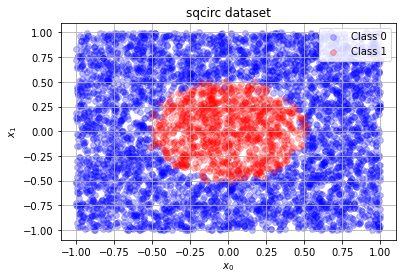

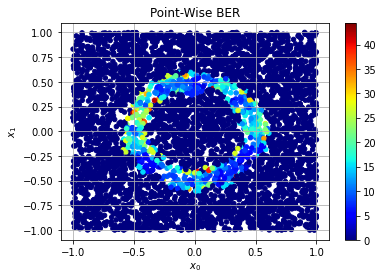

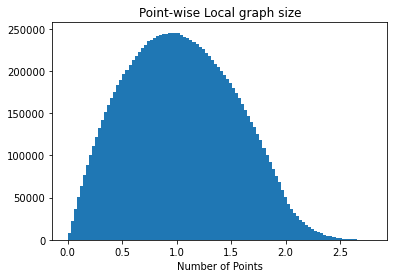

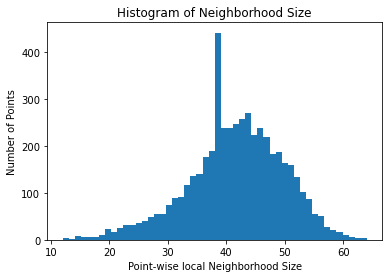

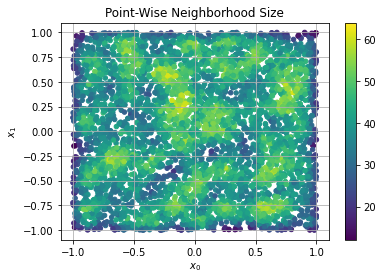

In [7]:
fig = plt.figure()

plt.figure()
plot_2d_dataset(xsqcirc, ysqcirc, title = 'sqcirc dataset')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

fig = plt.figure()
plt.scatter(xsqcirc[:, 0], xsqcirc[:, 1], c=pointwiseBER*100, s=20, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise BER')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')


plt.figure()
plt.hist(distancevec, bins = 100)
plt.title('Point-wise Local graph size')
plt.xlabel('Local graph size')
plt.xlabel('Number of Points')


plt.figure()
plt.hist(sum(mask), bins=50)
plt.title('Histogram of Neighborhood Size')
plt.xlabel('Point-wise local Neighborhood Size')
plt.ylabel('Number of Points')

fig = plt.figure()
plt.scatter(xsqcirc[:, 0], xsqcirc[:, 1], c=sum(mask), s=20, cmap=plt.cm.viridis)
plt.grid()
plt.colorbar()

plt.title('Point-Wise Neighborhood Size')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

Text(0, 0.5, '$x_1$')

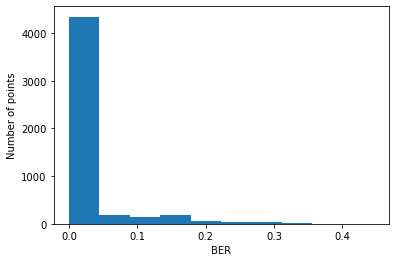

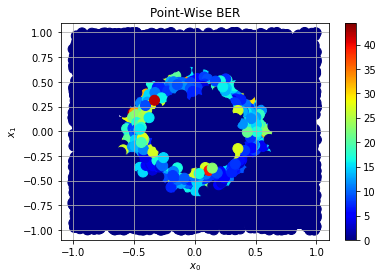

In [8]:

plt.figure()
plt.hist(pointwiseBER)
plt.xlabel('BER')
plt.ylabel('Number of points')

fig = plt.figure()
plt.scatter(xsqcirc[:, 0], xsqcirc[:, 1], c=pointwiseBER*100, s=100, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()

plt.title('Point-Wise BER')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

0.127


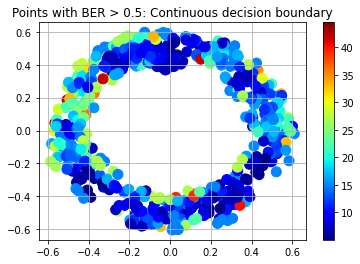

In [9]:
idxs = pointwiseBER>.05
fig = plt.figure()
plt.scatter(xsqcirc[idxs, 0], xsqcirc[idxs, 1], c=pointwiseBER[idxs]*100, s=100, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Points with BER > 0.5: Continuous decision boundary')
print(sum(idxs)/len(xsqcirc))

In [11]:
# def calc_importance_sampling(pointwiseBER, smoothing):
#     pointwiseBER[np.argwhere(pointwiseBER==0).ravel()]=1.
#     normalization = 0.
#     for point in pointwiseBER

Mean distance:	 2.508240882166083 	Neighborhood Threshold:	 1.2541204410830415


Text(0, 0.5, '$x_1$')

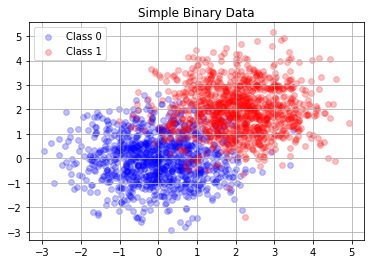

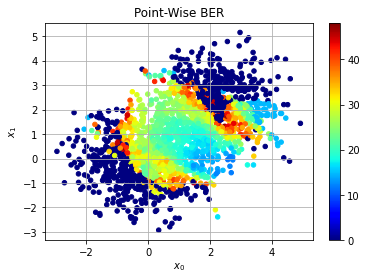

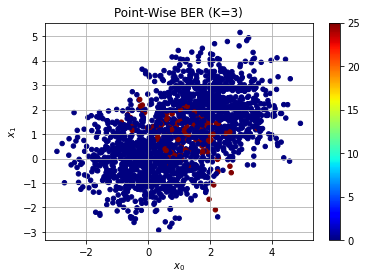

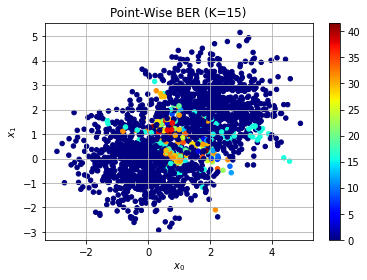

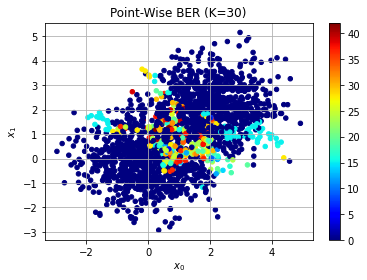

In [13]:
from sklearn.neighbors import KNeighborsClassifier
# from slkearn
x0, x1, labels = gen_simple_binary_data(N = 1000, mu_y = 2 * np.ones([1, 2]), ndims = 2)
xdata = np.vstack([x0, x1])

plot_2d_dataset(xdata, labels, 'Simple Binary Data')

adjacency_matrix = pairwise_distances(xdata, n_jobs=7)
connect_matrix = pairwise_distances(labels.reshape(-1,1), n_jobs=7)
gdist = np.matrix.round(adjacency_matrix, 5)
distancevec = squareform(gdist)

sigma_threshold = .5
neighborhood_radius = np.mean(squareform(gdist)) * sigma_threshold
mask = np.logical_and(gdist < neighborhood_radius, gdist>0.)
print('Mean distance:\t', np.mean(distancevec), '\tNeighborhood Threshold:\t', neighborhood_radius)

rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xdata, gdist = gdist, mask = mask, ylabel = labels) for idx in range(len(xdata)))
pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])
fig = plt.figure()
plt.scatter(xdata[:, 0], xdata[:, 1], c=pointwiseBER*100, s=20, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise BER')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xdata, gdist = gdist, mask = mask, ylabel = labels, neighborhood_size = 3) for idx in range(len(xdata)))
pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])

fig = plt.figure()
plt.scatter(xdata[:, 0], xdata[:, 1], c=pointwiseBER*100, s=20, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise BER (K=3)')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xdata, gdist = gdist, mask = mask, ylabel = labels, neighborhood_size = 15) for idx in range(len(xdata)))
pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])

fig = plt.figure()
plt.scatter(xdata[:, 0], xdata[:, 1], c=pointwiseBER*100, s=20, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise BER (K=15)')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xdata, gdist = gdist, mask = mask, ylabel = labels, neighborhood_size = 30) for idx in range(len(xdata)))
pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])

fig = plt.figure()
plt.scatter(xdata[:, 0], xdata[:, 1], c=pointwiseBER*100, s=20, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise BER (K=30)')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')


Mean distance:	 1.0360343767553515 	Neighborhood Threshold:	 0.15540515651330272
Mean distance:	 1.0360343767553515 	Neighborhood Threshold:	 0.5180171883776757


Text(0, 0.5, '$x_1$')

<Figure size 432x288 with 0 Axes>

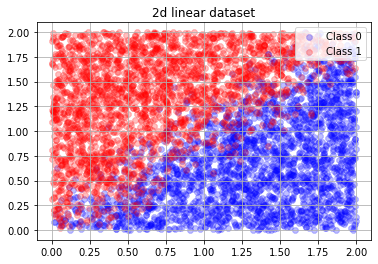

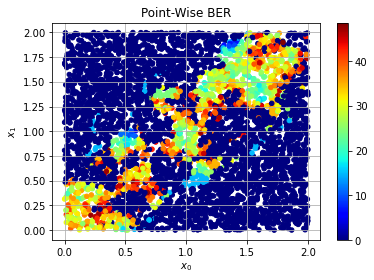

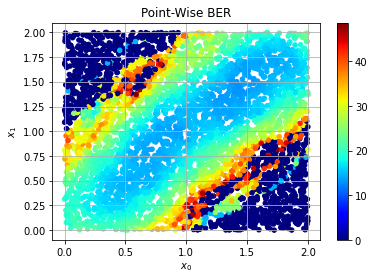

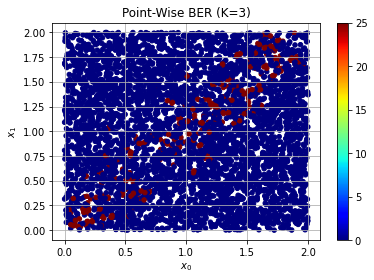

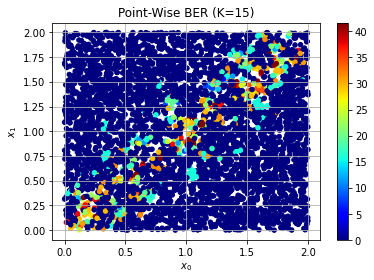

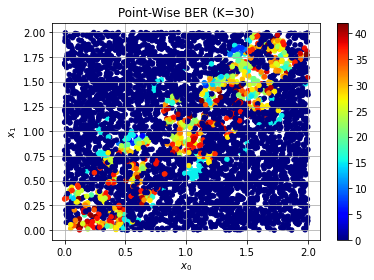

In [133]:
from sklearn.neighbors import KNeighborsClassifier

xlin, ylin = gen_linear_dataset(N=5000, sigma=.25, ndim=2)
adjacency_matrix = pairwise_distances(xlin, n_jobs=7)
connect_matrix = pairwise_distances(ylin.reshape(-1,1), n_jobs=7)
plt.figure()
plot_2d_dataset(xlin, ylin, title = '2d linear dataset')
gdist = np.matrix.round(adjacency_matrix, 5)
distancevec = squareform(gdist)
sigma_threshold = .15
neighborhood_radius = np.mean(squareform(gdist)) * sigma_threshold
print('Mean distance:\t', np.mean(distancevec), '\tNeighborhood Threshold:\t', neighborhood_radius)
# adjacency_matrix[:7, :7]
ylinnumeric = ylin.astype('float')
mask = gdist < neighborhood_radius
# [compute_pointwise_ber(idx, xdata = xlin, gdist = gdist, mask = mask, ylabel = ylinnumeric) for idx in range(len(xlin))]
rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xlin, gdist = gdist, mask = mask, ylabel = ylinnumeric) for idx in range(len(xlin)))

pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])
fig = plt.figure()
plt.scatter(xlin[:, 0], xlin[:, 1], c=pointwiseBER*100, s=20, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise BER')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

sigma_threshold = .5
neighborhood_radius = np.mean(squareform(gdist)) * sigma_threshold
print('Mean distance:\t', np.mean(distancevec), '\tNeighborhood Threshold:\t', neighborhood_radius)
# adjacency_matrix[:7, :7]
ylinnumeric = ylin.astype('float')
mask = gdist < neighborhood_radius
rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xlin, gdist = gdist, mask = mask, ylabel = ylinnumeric) for idx in range(len(xlin)))

pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])
fig = plt.figure()
plt.scatter(xlin[:, 0], xlin[:, 1], c=pointwiseBER*100, s=20, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise BER')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')


rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xlin, gdist = gdist, mask = mask, ylabel = ylinnumeric, neighborhood_size = 3) for idx in range(len(xlin)))
pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])

fig = plt.figure()
plt.scatter(xlin[:, 0], xlin[:, 1], c=pointwiseBER*100, s=20, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise BER (K=3)')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xlin, gdist = gdist, mask = mask, ylabel = ylinnumeric, neighborhood_size = 15) for idx in range(len(xlin)))
pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])

fig = plt.figure()
plt.scatter(xlin[:, 0], xlin[:, 1], c=pointwiseBER*100, s=20, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise BER (K=15)')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xlin, gdist = gdist, mask = mask, ylabel = ylinnumeric, neighborhood_size = 30) for idx in range(len(xlin)))
pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])

fig = plt.figure()
plt.scatter(xlin[:, 0], xlin[:, 1], c=pointwiseBER*100, s=20, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise BER (K=30)')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')


Mean distance:	 1.042318652748151 	Neighborhood Threshold:	 0.1042318652748151
Mean distance:	 1.042318652748151 	Neighborhood Threshold:	 0.5211593263740755


Text(0, 0.5, '$x_1$')

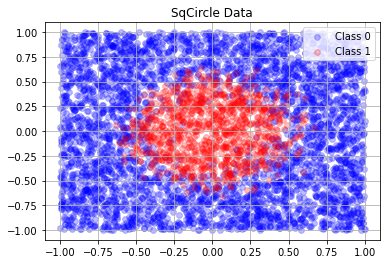

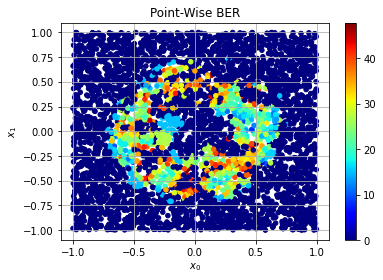

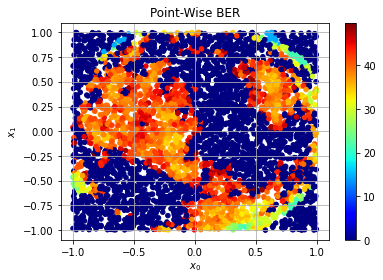

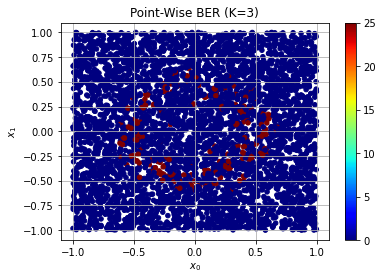

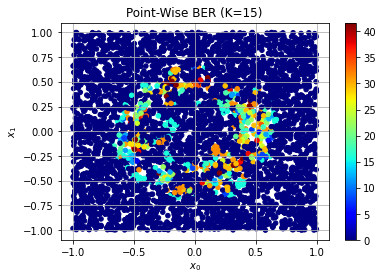

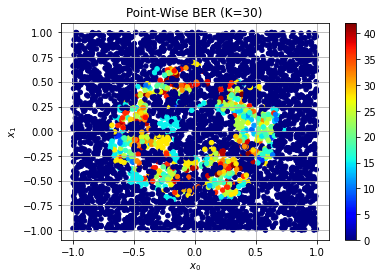

In [142]:
from sklearn.neighbors import KNeighborsClassifier
# from slkearn
x0square, x1circle, labels = inscribed_circle_dataset(N=5000, radius=.5, sidelen=2, sigma=.1)
xdata = np.vstack([x0square, x1circle])
# print(labels.shape)
# print(xdata.shape)
# plt.figure()
# plt.plot(a[:, 0], a[:, 1], ')
plot_2d_dataset(xdata, labels, 'SqCircle Data')
adjacency_matrix = pairwise_distances(xdata, n_jobs=7)
gdist = np.matrix.round(adjacency_matrix, 5)
distancevec = squareform(gdist)
sigma_threshold = .1
neighborhood_radius = np.mean(squareform(gdist)) * sigma_threshold
mask = gdist < neighborhood_radius
print('Mean distance:\t', np.mean(distancevec), '\tNeighborhood Threshold:\t', neighborhood_radius)

rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xdata, gdist = gdist, mask = mask, ylabel = labels) for idx in range(len(xdata)))
pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])
fig = plt.figure()
plt.scatter(xdata[:, 0], xdata[:, 1], c=pointwiseBER*100, s=20, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise BER')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

sigma_threshold = .5
neighborhood_radius = np.mean(squareform(gdist)) * sigma_threshold
print('Mean distance:\t', np.mean(distancevec), '\tNeighborhood Threshold:\t', neighborhood_radius)
# adjacency_matrix[:7, :7]
ylinnumeric = ylin.astype('float')
mask = gdist < neighborhood_radius
rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xlin, gdist = gdist, mask = mask, ylabel = labels) for idx in range(len(xlin)))

pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])
fig = plt.figure()
plt.scatter(xdata[:, 0], xdata[:, 1], c=pointwiseBER*100, s=20, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise BER')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xdata, gdist = gdist, mask = mask, ylabel = labels, neighborhood_size = 3) for idx in range(len(xdata)))
pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])

fig = plt.figure()
plt.scatter(xdata[:, 0], xdata[:, 1], c=pointwiseBER*100, s=20, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise BER (K=3)')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xdata, gdist = gdist, mask = mask, ylabel = labels, neighborhood_size = 15) for idx in range(len(xdata)))
pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])

fig = plt.figure()
plt.scatter(xdata[:, 0], xdata[:, 1], c=pointwiseBER*100, s=20, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise BER (K=15)')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xdata, gdist = gdist, mask = mask, ylabel = labels, neighborhood_size = 30) for idx in range(len(xdata)))
pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])

fig = plt.figure()
plt.scatter(xdata[:, 0], xdata[:, 1], c=pointwiseBER*100, s=20, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise BER (K=30)')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')


Mean distance:	 1.0461605300796157 	Neighborhood Threshold:	 0.10461605300796158
Mean distance:	 1.0461605300796157 	Neighborhood Threshold:	 0.5230802650398079


Text(0, 0.5, '$x_1$')

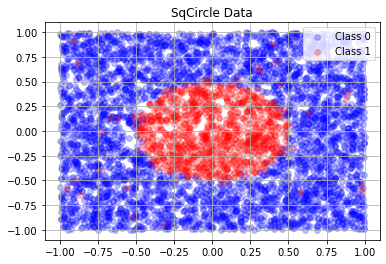

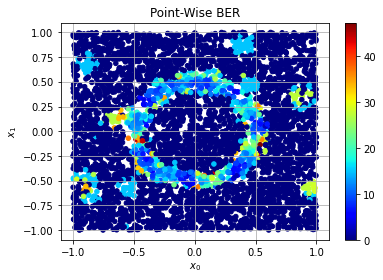

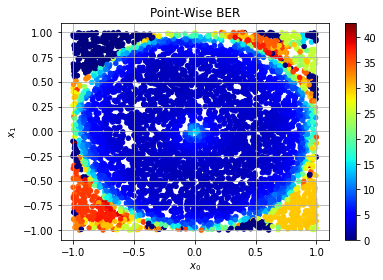

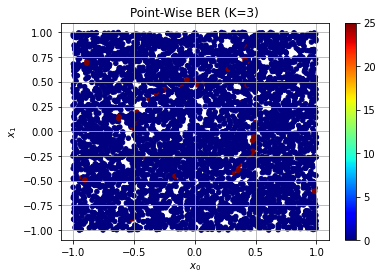

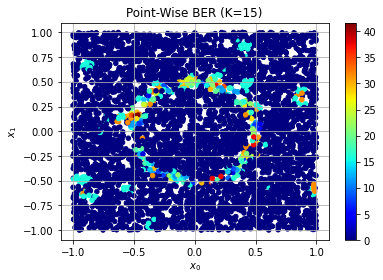

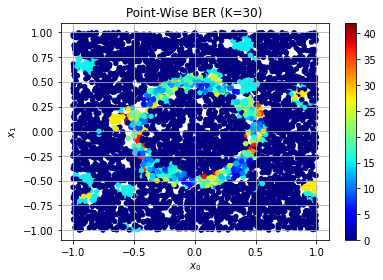

In [143]:
from sklearn.neighbors import KNeighborsClassifier
# from slkearn
x0square, x1circle, ysqcirc = inscribed_circle_dataset(N=5000, radius=.5, sidelen=2, sigma=.025)
xdata = np.vstack([x0square, x1circle])

plot_2d_dataset(xdata, labels, 'SqCircle Data')
adjacency_matrix = pairwise_distances(xdata, n_jobs=7)
gdist = np.matrix.round(adjacency_matrix, 5)
distancevec = squareform(gdist)
sigma_threshold = .1
neighborhood_radius = np.mean(squareform(gdist)) * sigma_threshold
mask = gdist < neighborhood_radius
print('Mean distance:\t', np.mean(distancevec), '\tNeighborhood Threshold:\t', neighborhood_radius)

rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xdata, gdist = gdist, mask = mask, ylabel = labels) for idx in range(len(xdata)))
pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])
fig = plt.figure()
plt.scatter(xdata[:, 0], xdata[:, 1], c=pointwiseBER*100, s=20, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise BER')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

sigma_threshold = .5
neighborhood_radius = np.mean(squareform(gdist)) * sigma_threshold
print('Mean distance:\t', np.mean(distancevec), '\tNeighborhood Threshold:\t', neighborhood_radius)
# adjacency_matrix[:7, :7]
ylinnumeric = ylin.astype('float')
mask = gdist < neighborhood_radius
rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xdata, gdist = gdist, mask = mask, ylabel = labels) for idx in range(len(xdata)))

pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])
fig = plt.figure()
plt.scatter(xdata[:, 0], xdata[:, 1], c=pointwiseBER*100, s=20, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise BER')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xdata, gdist = gdist, mask = mask, ylabel = labels, neighborhood_size = 3) for idx in range(len(xdata)))
pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])

fig = plt.figure()
plt.scatter(xdata[:, 0], xdata[:, 1], c=pointwiseBER*100, s=20, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise BER (K=3)')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xdata, gdist = gdist, mask = mask, ylabel = labels, neighborhood_size = 15) for idx in range(len(xdata)))
pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])

fig = plt.figure()
plt.scatter(xdata[:, 0], xdata[:, 1], c=pointwiseBER*100, s=20, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise BER (K=15)')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

rslts = Parallel(n_jobs=8)(delayed(compute_pointwise_ber)(idx, xdata = xdata, gdist = gdist, mask = mask, ylabel = labels, neighborhood_size = 30) for idx in range(len(xdata)))
pointwiseBER = np.array([r[0] for r in rslts])
pointwisedp = np.array([r[1] for r in rslts])
nsize = np.array([r[2] for r in rslts])

fig = plt.figure()
plt.scatter(xdata[:, 0], xdata[:, 1], c=pointwiseBER*100, s=20, cmap=plt.cm.jet)
plt.grid()
plt.colorbar()
plt.title('Point-Wise BER (K=30)')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
